In [125]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from sklearn.manifold import TSNE
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.cluster import KMeans
from sklearn.preprocessing import FunctionTransformer

In [2]:
from sklearn.preprocessing import StandardScaler

In [3]:
pd.set_option('max_columns', None)
pd.set_option('display.max_rows', 200)
pd.options.display.float_format = "{:,.2f}".format
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})

In [4]:
df = pd.read_csv('train.csv')

In [5]:
df.shape

(891, 12)

In [6]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.00,1,0,A/5 21171,7.25,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.00,1,0,PC 17599,71.28,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.00,0,0,STON/O2. 3101282,7.92,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.00,1,0,113803,53.10,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.00,0,0,373450,8.05,NaN,S


In [7]:
numerical_data = df.drop(['Survived', 'PassengerId'], axis=1).select_dtypes(['int64', 'float64'])
categorical_data = df.select_dtypes(['object'])

In [8]:
numerical_data.head()

,Pclass,Age,SibSp,Parch,Fare
0,3,22.00,1,0,7.25
1,1,38.00,1,0,71.28
2,3,26.00,0,0,7.92
3,1,35.00,1,0,53.10
4,3,35.00,0,0,8.05


In [9]:
categorical_data.head()

,Name,Sex,Ticket,Cabin,Embarked
0,"Braund, Mr. Owen Harris",male,A/5 21171,NaN,S
1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,PC 17599,C85,C
2,"Heikkinen, Miss. Laina",female,STON/O2. 3101282,NaN,S
3,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,113803,C123,S
4,"Allen, Mr. William Henry",male,373450,NaN,S


In [10]:
print(categorical_data.shape, numerical_data.shape)

(891, 5) (891, 5)


In [11]:
numerical_data.describe()

,Pclass,Age,SibSp,Parch,Fare
count,891.00,714.00,891.00,891.00,891.00
mean,2.31,29.70,0.52,0.38,32.20
std,0.84,14.53,1.10,0.81,49.69
min,1.00,0.42,0.00,0.00,0.00
25%,2.00,20.12,0.00,0.00,7.91
50%,3.00,28.00,0.00,0.00,14.45
75%,3.00,38.00,1.00,0.00,31.00
max,3.00,80.00,8.00,6.00,512.33


# Numerical data. EDA 

In [12]:
std = StandardScaler()
std_numerical_data = pd.DataFrame(std.fit_transform(numerical_data), columns=numerical_data.columns)

In [13]:
std_numerical_data.head()

,Pclass,Age,SibSp,Parch,Fare
0,0.83,-0.53,0.43,-0.47,-0.50
1,-1.57,0.57,0.43,-0.47,0.79
2,0.83,-0.25,-0.47,-0.47,-0.49
3,-1.57,0.37,0.43,-0.47,0.42
4,0.83,0.37,-0.47,-0.47,-0.49


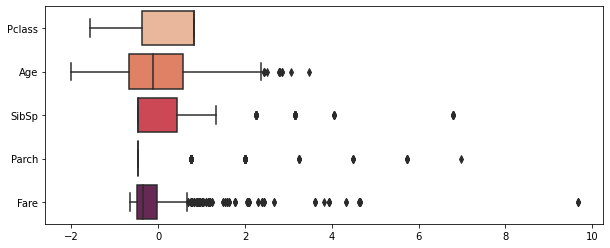

In [14]:
plt.figure(figsize=(10, 4))
sns.set_palette(sns.color_palette("rocket_r"))
sns.boxplot(data=std_numerical_data, orient='horizontal');

There is a problem with outliers.

**Generaly there are three options to handle outliers:** 

1. Remove them. 
2. Add additional feature that indicates whether records has outliers. 
3. Use log to dicrease the influence of.

### Missing values

In [15]:
numerical_data.isna().sum()

Pclass      0
Age       177
SibSp       0
Parch       0
Fare        0
dtype: int64

In [16]:
imputer = SimpleImputer(strategy='median')

In [17]:
filled_numerical_data = pd.DataFrame(imputer.fit_transform(numerical_data), columns=numerical_data.columns)

In [18]:
filled_numerical_data.shape

(891, 5)

In [19]:
filled_numerical_data.isna().sum()

Pclass    0
Age       0
SibSp     0
Parch     0
Fare      0
dtype: int64

### Age feature analysis

In [20]:
age_attribute = numerical_data.Age

In [21]:
age_attribute.describe()

count   714.00
mean     29.70
std      14.53
min       0.42
25%      20.12
50%      28.00
75%      38.00
max      80.00
Name: Age, dtype: float64

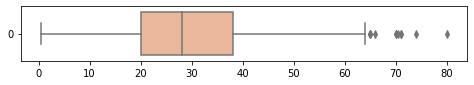

In [22]:
sns.set_palette(sns.color_palette("rocket_r"))
plt.figure(figsize=(8, 1))
sns.boxplot(data=age_attribute, orient='horizontal');

There are some outliers. I think the best solution will be to use IQR * 1.5 to manage them.

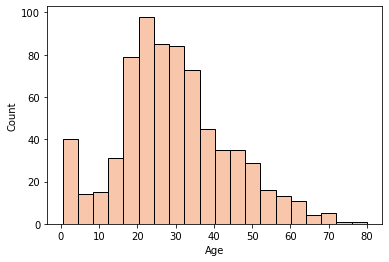

In [23]:
sns.histplot(age_attribute);

In [24]:
k2_score, pvalue = stats.normaltest(age_attribute.fillna(age_attribute.median()))

This function tests the null hypothesis that a sample comes from a normal distribution. 

In [25]:
alpha = 0.05

In [26]:
print(k2_score, pvalue)

53.46581133311897 2.454972229498001e-12


In [27]:
if pvalue < alpha:
    print("The null hypothesis can be rejected. We can assume that this data isn't normaly distributed.")
else:
    print("The null hypothesis cannot be rejected")

The null hypothesis can be rejected. We can assume that this data isn't normaly distributed.


The age data distributed pretty close to normal distribution so I can assume that if we get rid of outliers it will be normaly distributed

In [28]:
IQR = age_attribute.quantile(0.75) - age_attribute.quantile(0.25)

In [29]:
threshold = IQR * 1.5

In [30]:
lower_bound = age_attribute.quantile(0.25) - threshold
upper_bound = age_attribute.quantile(0.75) + threshold
age_attribute_without_outliers = age_attribute[(age_attribute > lower_bound) & (age_attribute < upper_bound)]

In [31]:
print(age_attribute.shape, age_attribute_without_outliers.shape)

(891,) (703,)


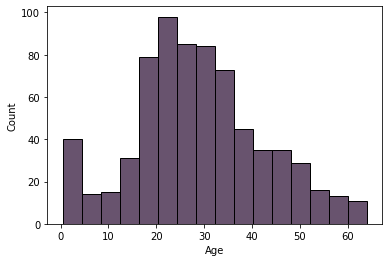

In [32]:
sns.set_palette(sns.color_palette("rocket"))
sns.histplot(age_attribute_without_outliers);

In [33]:
def check_normal_distribution(data):
    k2_score, pvalue = stats.normaltest(data.fillna(data.median()))
    alpha = 0.05
    
    print('Alpha level: ' + str(alpha))
    if pvalue < alpha:
        print("The null hypothesis can be rejected. We can assume that this data isn't normaly distributed.")
    else:
        print("The null hypothesis cannot be rejected. The data is normaly distributed")

In [34]:
check_normal_distribution(age_attribute_without_outliers)

Alpha level: 0.05
The null hypothesis cannot be rejected. The data is normaly distributed


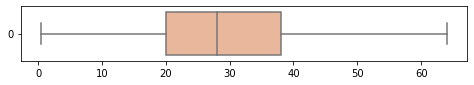

In [35]:
sns.set_palette(sns.color_palette("rocket_r"))
plt.figure(figsize=(8, 1))
sns.boxplot(data=age_attribute_without_outliers, orient='horizontal');

In [36]:
age_attribute.shape[0] - age_attribute_without_outliers.shape[0]

188

Using first strategy we lose a lot of data. So it will be better to use second or third stategy

### Pclass feature analysis

In [37]:
pclass_attribute = numerical_data.Pclass

In [38]:
pclass_attribute.head()

0    3
1    1
2    3
3    1
4    3
Name: Pclass, dtype: int64

In [39]:
pclass_attribute.value_counts()

3    491
1    216
2    184
Name: Pclass, dtype: int64

I would say that is categorical ordered data, because it represents ticket class (1 - Upper, 2 - Middle, 3 - Lower)

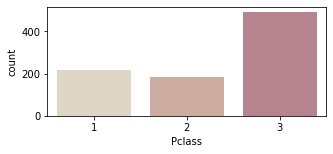

In [40]:
plt.figure(figsize=(5, 2))
sns.set_palette(sns.color_palette("ch:s=-.2,r=.6"))
sns.countplot(x=pclass_attribute);

### SibSp feature analysis

Number of siblings / spouses aboard the Titanic

In [41]:
sib_sp_attribute = numerical_data.SibSp

In [42]:
sib_sp_attribute.head()

0    1
1    1
2    0
3    1
4    0
Name: SibSp, dtype: int64

In [43]:
sib_sp_attribute.value_counts()

0    608
1    209
2     28
4     18
3     16
8      7
5      5
Name: SibSp, dtype: int64

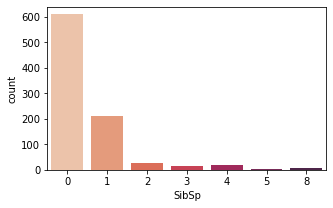

In [44]:
plt.figure(figsize=(5, 3))
sns.set_palette(sns.color_palette("rocket_r", n_colors=8))
sns.countplot(x=sib_sp_attribute);

In [45]:
Q3 = sib_sp_attribute.quantile(0.75)
Q1 = sib_sp_attribute.quantile(0.25)
IQR = Q3 - Q1
IQR

1.0

In [46]:
lower_bound = Q1 - IQR * 1.5
upper_bound = Q3 + IQR * 1.5

In [47]:
sib_sp_attribute.shape

(891,)

In [48]:
sib_sp_attribute_without_outliers = sib_sp_attribute[(sib_sp_attribute > lower_bound) & (sib_sp_attribute < upper_bound)]

In [49]:
loss = sib_sp_attribute.shape[0] - sib_sp_attribute_without_outliers.shape[0]
loss

46

In [50]:
upper_bound

2.5

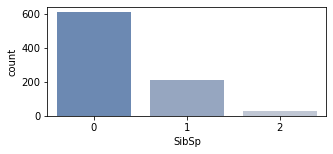

In [51]:
plt.figure(figsize=(5, 2))
sns.set_palette(sns.color_palette("vlag", 8))
sns.countplot(x=sib_sp_attribute_without_outliers);

I will add new feature which will indicate whether it is outlier or not

### Parch 

Number of parents / children aboard the Titanic

In [52]:
parch_attribute = numerical_data.Parch

In [53]:
parch_attribute.value_counts()

0    678
1    118
2     80
5      5
3      5
4      4
6      1
Name: Parch, dtype: int64

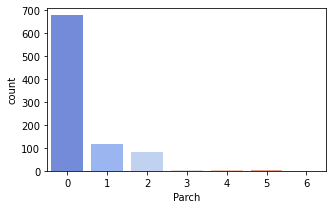

In [54]:
plt.figure(figsize=(5, 3))
sns.set_palette(sns.color_palette("coolwarm", 7))
sns.countplot(x=parch_attribute);

In [55]:
Q3 = parch_attribute.quantile(0.75)
Q1 = parch_attribute.quantile(0.25)
IQR = Q3 - Q1
IQR

0.0

### Fare feature analysis

Passenger fare

In [56]:
fare_attribute = numerical_data.Fare

In [57]:
fare_attribute.head()

0    7.25
1   71.28
2    7.92
3   53.10
4    8.05
Name: Fare, dtype: float64

In [58]:
fare_attribute.describe()

count   891.00
mean     32.20
std      49.69
min       0.00
25%       7.91
50%      14.45
75%      31.00
max     512.33
Name: Fare, dtype: float64

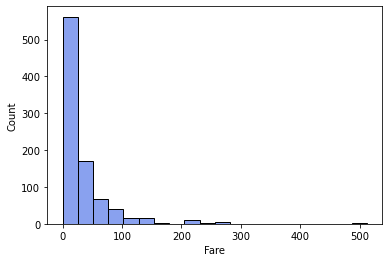

In [59]:
sns.set_palette(sns.color_palette("coolwarm", 7))
sns.histplot(fare_attribute, bins=20);

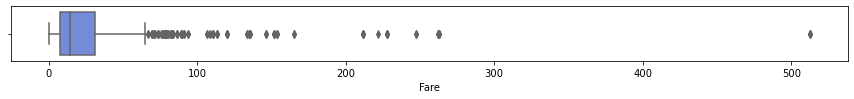

In [60]:
plt.figure(figsize=(15, 1))
sns.boxplot(x=fare_attribute);

In [61]:
def get_outliers_boundaries(data):
    Q3 = data.quantile(0.75)
    Q1 = data.quantile(0.25)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - IQR * 1.5
    upper_bound = Q3 + IQR * 1.5
    
    return lower_bound, upper_bound

In [62]:
lower_bound, upper_bound = get_outliers_boundaries(fare_attribute)

In [63]:
print(lower_bound, upper_bound)

-26.724 65.6344


In [64]:
fare_attribute_without_outliers = fare_attribute[(fare_attribute > lower_bound) & (fare_attribute < upper_bound)]

In [65]:
loss = fare_attribute.shape[0] - fare_attribute_without_outliers.shape[0]

In [66]:
loss

116

There is a big part of outliers in this series. I can't just remove them, so I'm going to use 2 or 3 strategy (additional attribute or put it under the log).

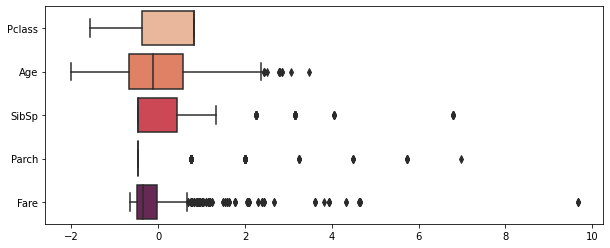

In [67]:
plt.figure(figsize=(10, 4))
sns.set_palette(sns.color_palette("rocket_r"))
sns.boxplot(data=std_numerical_data, orient='horizontal');

## Clustering numerical data using t-SNE

In [68]:
tsne = TSNE(random_state=17)
tsne_representation = tsne.fit_transform(numerical_data.fillna(age_attribute.median()))

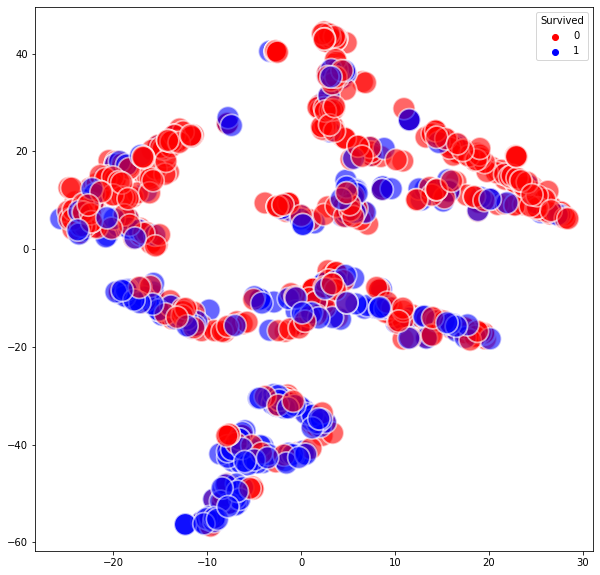

In [69]:
plt.figure(figsize=(10, 10))
sns.set_palette(sns.color_palette(['red', 'blue']))
sns.scatterplot(x=tsne_representation[:, 0], y=tsne_representation[:, 1], alpha=0.6, s=500, hue=df.Survived);

There are for sure some clusters, so I can use them to create a custom attribute which will define the cluster number and hopefully will improme the classification accuracy

## Feature Engineering using clustering

In [70]:
clusterer = KMeans(4)
clusterer.fit(filled_numerical_data)

KMeans(n_clusters=4)

In [71]:
filled_numerical_data.head()

,Pclass,Age,SibSp,Parch,Fare
0,3.00,22.00,1.00,0.00,7.25
1,1.00,38.00,1.00,0.00,71.28
2,3.00,26.00,0.00,0.00,7.92
3,1.00,35.00,1.00,0.00,53.10
4,3.00,35.00,0.00,0.00,8.05


In [72]:
class Clusterizer(BaseEstimator, TransformerMixin):
    
    def __init__(self, clusterizer, features):
        self.clusterizer = clusterizer
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X = X.copy()
        X['Cluster'] = self.clusterizer.predict(X)
        
        return X

In [73]:
clusterizer = Clusterizer(clusterer, numerical_data.columns)

In [74]:
clusterizer.fit_transform(filled_numerical_data).head()

,Pclass,Age,SibSp,Parch,Fare,Cluster
0,3.00,22.00,1.00,0.00,7.25,0
1,1.00,38.00,1.00,0.00,71.28,2
2,3.00,26.00,0.00,0.00,7.92,0
3,1.00,35.00,1.00,0.00,53.10,2
4,3.00,35.00,0.00,0.00,8.05,0


## Age Feature Discretization

1. Child = 0-12 yrs
2. Teen = 13-19 yrs
3. Adult = 20-39 yrs
4. Middle Age Adult = 40-59 yrs
5. Senior Adult = 60+

In [89]:
age_attribute.head()

0   22.00
1   38.00
2   26.00
3   35.00
4   35.00
Name: Age, dtype: float64

In [90]:
filled_age_attribute = age_attribute.fillna(age_attribute.median())

In [91]:
digitized_age_attribute = pd.DataFrame(np.digitize(filled_age_attribute, bins=[12, 19, 39, 59, 150], right=True).astype('str'),
                                      columns=['Age'])

In [92]:
digitized_age_attribute.head()

,Age
0,2
1,2
2,2
3,2
4,2


In [93]:
encoder = OneHotEncoder()

In [94]:
discretized_age_attribute = encoder.fit_transform(digitized_age_attribute).todense()

In [95]:
age_catigories = ['Child', 'Teen', 'Adult', 'MiddleAgeAdult', 'SeniorAdult'] 
discretized_age_attribute = pd.DataFrame(discretized_age_attribute, columns=age_catigories)

In [96]:
discretized_age_attribute.head()

,Child,Teen,Adult,MiddleAgeAdult,SeniorAdult
0,0.00,0.00,1.00,0.00,0.00
1,0.00,0.00,1.00,0.00,0.00
2,0.00,0.00,1.00,0.00,0.00
3,0.00,0.00,1.00,0.00,0.00
4,0.00,0.00,1.00,0.00,0.00


In [100]:
class AgeDiscretizer(BaseEstimator, TransformerMixin):
    
    def __init__(self, encoder):
        self.age_categories = ['Child', 'Teen', 'Adult', 'MiddleAgeAdult', 'SeniorAdult']
        self.age_groups = [12, 19, 39, 59, 250]
        self.encoder = encoder
        self.dependent_feature_to_drop = 'Child'
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X = X.copy()
        age_feature = X['Age']
        
        discretized_data = pd.DataFrame(np.digitize(age_feature, bins=self.age_groups, right=True).astype('str'),
                                       columns=['Age'])
        
        discretized_data = pd.DataFrame(self.encoder.fit_transform(discretized_data).todense(),
                                        columns=self.age_categories)

        result = pd.concat([X, discretized_data], axis=1)
        result = result.drop(['Age', 'Child'], axis=1)

        return result

In [101]:
age_discretizer = AgeDiscretizer(encoder)

In [102]:
age_discretizer.fit_transform(filled_numerical_data).head()

,Pclass,SibSp,Parch,Fare,Teen,Adult,MiddleAgeAdult,SeniorAdult
0,3.00,1.00,0.00,7.25,0.00,1.00,0.00,0.00
1,1.00,1.00,0.00,71.28,0.00,1.00,0.00,0.00
2,3.00,0.00,0.00,7.92,0.00,1.00,0.00,0.00
3,1.00,1.00,0.00,53.10,0.00,1.00,0.00,0.00
4,3.00,0.00,0.00,8.05,0.00,1.00,0.00,0.00


## Outliers

In [120]:
def add_outliers_markers(data):
    data = data.copy()
    features_to_process = ['Age', 'SibSp']
    
    for feature in features_to_process:
        
        Q3 = data[feature].quantile(0.75)
        Q1 = data[feature].quantile(0.25)
        IQR = Q3 - Q1
        threshold = IQR * 1.5
        
        lower_bound = Q1 - threshold
        upper_bound = Q3 + threshold
        
        result = ((data[feature] < lower_bound) | (data[feature] > upper_bound)).rename(feature + '_outlier').astype(int)
        data = pd.concat([data, result], axis=1)
        
    return data

In [130]:
add_outliers_markers(filled_numerical_data)['SibSp_outlier'].value_counts()

0    845
1     46
Name: SibSp_outlier, dtype: int64

In [132]:
outliers_highlighter = FunctionTransformer(add_outliers_markers)

In [133]:
outliers_highlighter.fit_transform(filled_numerical_data).head()

,Pclass,Age,SibSp,Parch,Fare,Age_outlier,SibSp_outlier
0,3.00,22.00,1.00,0.00,7.25,0,0
1,1.00,38.00,1.00,0.00,71.28,0,0
2,3.00,26.00,0.00,0.00,7.92,0,0
3,1.00,35.00,1.00,0.00,53.10,0,0
4,3.00,35.00,0.00,0.00,8.05,0,0


## Conclusion:
```
numerical data:
                                                             
- 1 -> SimpleImputer( strategy='median' ) - 2 -> OutliersHighlighter() ->
   
         [ 'Age' ] - 5 -> AgeDiscretizer( encoder #fitted on train data )- - 
       /                                                                     \
3 - >  - - [all] - 4 -> Clusterizing( clusterizer #fitted on train data )  - - - > RESULT

``` 
   
- Pclass: leave without any changes
- Age: Feature Discretization:

1. Child = 0-12 yrs
2. Teen = 13-19 yrs
3. Adult = 20-39 yrs
4. Middle Age Adult = 40-59 yrs
5. Senior Adult = 60+

I will remove child as dependent variable
	
- SibSp: add binary feature which indicates whether it's outlier or not.
- Parch: leave without any changes
- Fare: put it under the logarithm 

To set up a numerical pipeline I need to create a custom class that tracks outliers and creates new attribute based on them (feature_is_outlier 1 - True, 0 - False). 

To handle missing values I'm going to use SimpleImputer with 'median' strategy